# InstaCart－Predict Trip Duration
#### by RN, 2016.07.07

In [2]:
import numpy as np
import pandas as pd
% matplotlib inline

###  Load csv datasets

In [3]:
train = pd.read_csv("train_trips.csv")
train.head(3)

,trip_id,store_id,shopper_id,shopping_started_at,shopping_ended_at
0,74387,1,760,2013-12-31 16:00:58-08:00,2013-12-31 16:48:58-08:00
1,74381,3,382,2013-12-31 16:02:00-08:00,2013-12-31 16:49:00-08:00
2,74382,6,493,2013-12-31 16:02:26-08:00,2013-12-31 16:25:26-08:00


In [4]:
test = pd.read_csv("test_trips.csv")
test.head(3)

,trip_id,store_id,shopper_id,shopping_started_at
0,131131,1,1056,2014-03-17 13:57:59-07:00
1,131154,3,1090,2014-03-17 14:02:06-07:00
2,131148,1,1138,2014-03-17 14:03:09-07:00


In [5]:
shoppers = pd.read_csv("shoppers.csv")
shoppers.head(3)

,shopper_id,shopper_hired_date,shopper_birth_year
0,884,2014-01-22 14:06:24-08:00,1983
1,476,2013-09-24 20:12:53-07:00,1990
2,1056,2014-02-10 13:54:38-08:00,1988


In [6]:
trip = pd.read_csv("trip_items.csv")
trip.head(3)

,trip_id,item_id,item_department,item_needs_weighed
0,74363,73671,Beverages,1
1,74363,74185,Pantry,1
2,74363,77267,Snacks,1


### Integrate multiple datasources
* train, shoppers, trip
* test, shoppers, trip

In [7]:
traindf = train.merge(shoppers, on = 'shopper_id')
#trainmerge = traindf.merge(trip, on = 'trip_id')

testdf = test.merge(shoppers, on = 'shopper_id')
#testmerge = testdf.merge(trip, on = 'trip_id')

print len(train)
print len(train.columns)
print len(traindf)
print len(traindf.columns)
#print len(trainmerge)

print len(test)
print len(test.columns)
print len(testdf)
print len(testdf.columns)
#print len(testmerge)

23000
5
23000
7
5460
4
5460
6


In [8]:
# check number of na values in each variables
x = traindf.isnull().sum(axis = 1).tolist()
y = float(sum(x))/(traindf.shape[0]*traindf.shape[1])

print 'Fraction nulls = ', y

Fraction nulls =  0.0


In [9]:
x = testdf.isnull().sum(axis = 1).tolist()
y = float(sum(x))/(testdf.shape[0]*traindf.shape[1])
print 'Fraction nulls = ', y

Fraction nulls =  0.0


In [10]:
print (traindf.columns)
print (testdf.columns)

Index([u'trip_id', u'store_id', u'shopper_id', u'shopping_started_at',
       u'shopping_ended_at', u'shopper_hired_date', u'shopper_birth_year'],
      dtype='object')
Index([u'trip_id', u'store_id', u'shopper_id', u'shopping_started_at',
       u'shopper_hired_date', u'shopper_birth_year'],
      dtype='object')


In [11]:
print 'Train shopper_id', len(pd.unique(traindf['shopper_id']))
print 'Test shopper_id', len(pd.unique(testdf['shopper_id']))
print 'Shopper id', len(pd.unique(shoppers['shopper_id']))

Train shopper_id 282
Test shopper_id 195
Shopper id 303


In [12]:
print 'Train trip_id', len(pd.unique(traindf['trip_id']))
print 'Test trip_id', len(pd.unique(testdf['trip_id']))
print 'Trip id', len(pd.unique(trip['trip_id']))

Train trip_id 23000
Test trip_id 5460
Trip id 28467


## Decompose and Aggregate Features

In [13]:
traindf.iloc[0]

trip_id                                    74387
store_id                                       1
shopper_id                                   760
shopping_started_at    2013-12-31 16:00:58-08:00
shopping_ended_at      2013-12-31 16:48:58-08:00
shopper_hired_date     2013-12-19 11:25:11-08:00
shopper_birth_year                          1987
Name: 0, dtype: object

In [14]:
# get shoppers experience year and age
# (1) shopping duration
from datetime import datetime
traindf['shopping_ended_at'] = traindf['shopping_ended_at'].map(lambda x: x[0:19])
traindf['shopping_started_at'] = traindf['shopping_started_at'].map(lambda x:x[0:19])
traindf['shopper_hired_date'] = traindf['shopper_hired_date'].map(lambda x:x[0:19])
traindf['end_time'] = pd.to_datetime(traindf['shopping_ended_at']) # convert traindf['shopping_ended_at'] from string to datatime
traindf['start_time'] = pd.to_datetime(traindf['shopping_started_at'])
traindf['hire_date'] = pd.to_datetime(traindf['shopper_hired_date'])
traindf['dur'] = traindf['end_time'] - traindf['start_time']
traindf['exp'] = traindf['start_time'] - traindf['hire_date']
traindf['minutes'] = traindf.dur.apply(lambda x: round(pd.Timedelta(x).total_seconds()//60)) 
traindf['seconds'] = traindf.dur.apply(lambda x: round(pd.Timedelta(x).total_seconds())) 

# (2) shopper age and experience
traindf['age'] = traindf.hire_date.apply(lambda x: x.year) - traindf.shopper_birth_year
traindf['exp'] = traindf.exp.apply(lambda x: round(pd.Timedelta(x).total_seconds()//(3600*24))) # experience in months

In [15]:
# get shopping is weekday, holiday,traffic hour
traindf['weekday'] = traindf.start_time.apply(lambda x: x.weekday())
traindf['start_hour'] = traindf.start_time.apply(lambda x: x.hour)
traindf['rush_hour'] = traindf.start_hour.apply(lambda x:(x >= 6 & x <= 9) & (x >= 16 & x <= 20))# experience in months
traindf['rush_hour'] = traindf.rush_hour.astype(int)

In [16]:
traindf.head(3)

,trip_id,store_id,shopper_id,shopping_started_at,shopping_ended_at,shopper_hired_date,shopper_birth_year,end_time,start_time,hire_date,dur,exp,minutes,seconds,age,weekday,start_hour,rush_hour
0,74387,1,760,2013-12-31 16:00:58,2013-12-31 16:48:58,2013-12-19 11:25:11,1987,2013-12-31 16:48:58,2013-12-31 16:00:58,2013-12-19 11:25:11,00:48:00,12,48,2880,26,1,16,1
1,74410,1,760,2013-12-31 16:56:58,2013-12-31 17:49:58,2013-12-19 11:25:11,1987,2013-12-31 17:49:58,2013-12-31 16:56:58,2013-12-19 11:25:11,00:53:00,12,53,3180,26,1,16,1
2,74659,3,760,2014-01-01 18:05:50,2014-01-01 18:55:50,2013-12-19 11:25:11,1987,2014-01-01 18:55:50,2014-01-01 18:05:50,2013-12-19 11:25:11,00:50:00,13,50,3000,26,2,18,1


In [17]:
# error in the dataset
# one shopper started to work even before he/she was hired
pd.unique(traindf[traindf['exp']<0]['shopper_id'])

array([1099], dtype=int64)

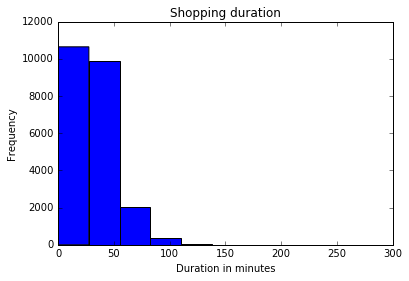

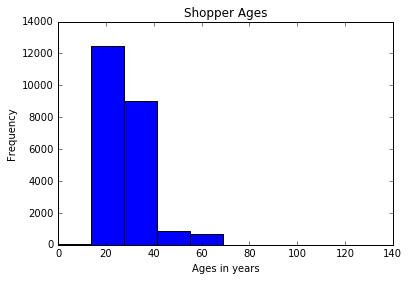

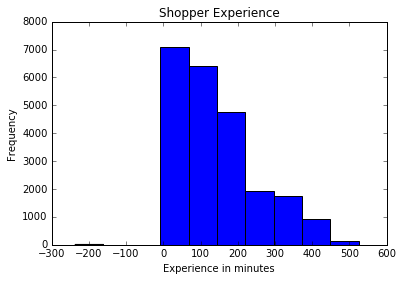

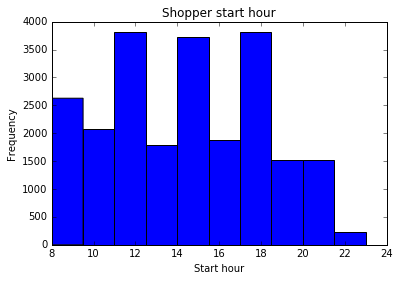

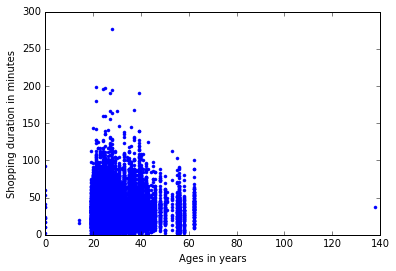

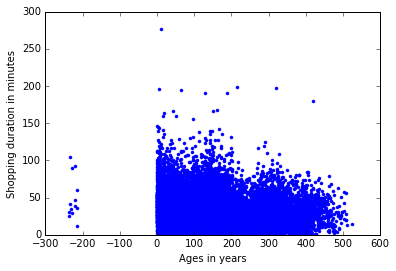

In [18]:
import matplotlib.pyplot as plt

plt.hist(traindf['minutes'])
plt.title('Shopping duration')
plt.xlabel('Duration in minutes')
plt.ylabel('Frequency')
plt.show()


plt.hist(traindf['age'])
plt.title('Shopper Ages')
plt.xlabel('Ages in years')
plt.ylabel('Frequency')
plt.show()

plt.hist(traindf['exp'])
plt.title('Shopper Experience')
plt.xlabel('Experience in minutes')
plt.ylabel('Frequency')
plt.show()

plt.hist(traindf['start_hour'])
plt.title('Shopper start hour')
plt.xlabel('Start hour')
plt.ylabel('Frequency')
plt.show()

plt.plot(traindf[traindf['minutes']>0]['age'],traindf[traindf['minutes']>0]['minutes'],'.')
plt.xlabel('Ages in years')
plt.ylabel('Shopping duration in minutes')
plt.show()

plt.plot(traindf[traindf['minutes']>0]['exp'],traindf[traindf['minutes']>0]['minutes'],'.')
plt.xlabel('Ages in years')
plt.ylabel('Shopping duration in minutes')
plt.show()

In [19]:
len(traindf[traindf['seconds']==0])
# some shopping duration is 0, which should be invalid

942

In [20]:
traindf.head(3)

,trip_id,store_id,shopper_id,shopping_started_at,shopping_ended_at,shopper_hired_date,shopper_birth_year,end_time,start_time,hire_date,dur,exp,minutes,seconds,age,weekday,start_hour,rush_hour
0,74387,1,760,2013-12-31 16:00:58,2013-12-31 16:48:58,2013-12-19 11:25:11,1987,2013-12-31 16:48:58,2013-12-31 16:00:58,2013-12-19 11:25:11,00:48:00,12,48,2880,26,1,16,1
1,74410,1,760,2013-12-31 16:56:58,2013-12-31 17:49:58,2013-12-19 11:25:11,1987,2013-12-31 17:49:58,2013-12-31 16:56:58,2013-12-19 11:25:11,00:53:00,12,53,3180,26,1,16,1
2,74659,3,760,2014-01-01 18:05:50,2014-01-01 18:55:50,2013-12-19 11:25:11,1987,2014-01-01 18:55:50,2014-01-01 18:05:50,2013-12-19 11:25:11,00:50:00,13,50,3000,26,2,18,1


### One-hot encoding

In [21]:
# get train dataframe
traindf_use = traindf
traindf_use.drop(['trip_id','store_id', 'shopping_started_at','shopping_ended_at','shopper_hired_date',
                  'shopper_birth_year','end_time','start_time', 'hire_date','dur'], axis = 1, inplace = True)
traindf_use.head(3)

,shopper_id,exp,minutes,seconds,age,weekday,start_hour,rush_hour
0,760,12,48,2880,26,1,16,1
1,760,12,53,3180,26,1,16,1
2,760,13,50,3000,26,2,18,1


In [22]:
# create dummy variable
traindf_shopper = pd.get_dummies(traindf_use['shopper_id'])
traindf_weekday = pd.get_dummies(traindf_use['weekday'])
traindf_starthour = pd.get_dummies(traindf_use['start_hour'])

traindf_dummy = pd.concat([traindf_use,traindf_shopper,traindf_weekday,traindf_starthour], axis= 1)
traindf_dummy.drop(['shopper_id','weekday','start_hour','minutes'], axis = 1, inplace = True)
traindf_dummy.head(3)

,exp,seconds,age,rush_hour,17,38,41,49,52,55,...,14,15,16,17,18,19,20,21,22,23
0,12,2880,26,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,12,3180,26,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,13,3000,26,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [23]:
# normalize features
from sklearn import preprocessing

colnames = traindf_dummy.columns
x = traindf_dummy.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = colnames
df['seconds'] = traindf_dummy['seconds']

In [24]:
df.head(3)


,exp,seconds,age,rush_hour,17,38,41,49,52,55,...,14,15,16,17,18,19,20,21,22,23
0,0.326772,2880,0.188406,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0.326772,3180,0.188406,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0.328084,3000,0.188406,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### Split training and testing

In [25]:
from sklearn.cross_validation import train_test_split
Xs = df.drop(['seconds'], axis = 1)
y = df['seconds']
X_train, X_test, y_train, y_test = train_test_split(Xs,y, test_size = 0.2, random_state = 9)

In [26]:
X_train.head(3)

,exp,age,rush_hour,17,38,41,49,52,55,59,...,14,15,16,17,18,19,20,21,22,23
8638,0.725722,0.239130,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2981,0.460630,0.289855,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
14613,0.448819,0.253623,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
y_train.head(3)

8638      660
2981     4560
14613     420
Name: seconds, dtype: float64

### Prediction

In [41]:
# Create linear regression object
from sklearn import linear_model

regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# The coefficients
# print('Coefficients: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %2.f"
     %  np.mean((regr.predict(X_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_test, y_test))

# Plot outputs
# plt.scatter(X_test, y_test,  color='black')
#plt.plot(X_test, regr.predict(X_test), color='blue','.')

#plt.xticks(())
#plt.yticks(())

#plt.show()

Residual sum of squares: 41491347815309122559025348608
Variance score: -27934096000584289091584.00


In [37]:
# Ridge linear regrssion
clf = linear_model.Ridge (alpha = 5.0)
clf.fit(X_train, y_train)

# The coefficients
# print('Coefficients: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %2.f"
     %  np.mean((clf.predict(X_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_test, y_test))


Residual sum of squares: 1133984
Variance score: -27934096000584289091584.00


In [34]:
# Ridge Complexity
clf = linear_model.RidgeCV (alphas = [0.1, 1.0, 10.0])
clf.fit(X_train, y_train)

clf.alpha_

1.0

In [39]:
# lASSO linear regrssion
clf = linear_model.Lasso (alpha = 0.5)
clf.fit(X_train, y_train)

# The coefficients
# print('Coefficients: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %2.f"
     %  np.mean((clf.predict(X_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_test, y_test))

Residual sum of squares: 1137568
Variance score: -27934096000584289091584.00
